In [6]:
# Mount point in google drive, comment it out if runner in other platform
import os
from google.colab import drive
MOUNTPOINT = '/content/gdrive'
DATADIR = os.path.join(MOUNTPOINT, 'My Drive', 'SMCD')
drive.mount(MOUNTPOINT)

import sys
sys.path.insert(0,'/content/gdrive/My Drive/SMCD')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!pip install graphviz
!pip install networkx
!pip install torch-geometric
!pip install torch torchvision
!pip install torch_xla
!pip install transformers

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_i

In [ ]:
# Only run this if you want TPU
# !pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

In [7]:
# Mention all the imports
from   collections import defaultdict
from   graphviz import Digraph
import matplotlib.pyplot as plt
import networkx as nx
import nltk
from   nltk import ngrams
from   nltk.corpus import stopwords
import numpy as np
import os
import pandas as pd
import re
from   sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from   torch_geometric.data import Data, DataLoader
import torch_geometric
from   torch_geometric.nn import GCNConv
from   torch_geometric.utils import to_networkx
import torch
import torch_xla
import torch_xla.core.xla_model as xm
import torch.nn as nn
import torch.nn.functional as F
import torch
from   tqdm import tqdm
from   util.get_stock_price import get_open_close_prices
from   util.predict import predict_for_singletext
import warnings

nltk.download('stopwords')
warnings.filterwarnings("ignore", category=FutureWarning)
tqdm.pandas()

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
# Read the csv file
stocks = pd.read_csv(os.path.join(DATADIR, 'dataset', 'stocks_cleaned.csv'))
stockerbot = pd.read_csv(os.path.join(DATADIR, 'dataset', 'stockerbot-export.csv'), error_bad_lines=False)
stockerbot = stockerbot.drop(columns=['id', 'url', 'verified'])

# Casting the columns acrroding to our use
stockerbot["timestamp_alter"] = pd.to_datetime(stockerbot["timestamp"])
stockerbot["text"] = stockerbot["text"].astype(str)
stockerbot["company_names"] = stockerbot["company_names"].astype("category")
stockerbot["symbols"] = stockerbot["symbols"].astype("category")
stockerbot["source"] = stockerbot["source"].astype("category")


# Create separate date & time columns for easier manipulation
stockerbot['date'] = stockerbot['timestamp_alter'].dt.date
stockerbot['time'] = stockerbot['timestamp_alter'].dt.time

# Handeling the missing values
stockerbot.isnull().any()
stockerbot[stockerbot['company_names'].isnull()]

# Removing links from the tweets
def remove_urls(text):
    url_pattern = r'https?://\S+|www\.\S+'
    return re.sub(url_pattern, '', text)

stockerbot['text'] = stockerbot['text'].progress_apply(remove_urls)
stockerbot.dtypes

Skipping line 731: expected 8 fields, saw 13
Skipping line 2836: expected 8 fields, saw 15
Skipping line 3058: expected 8 fields, saw 12
Skipping line 3113: expected 8 fields, saw 12
Skipping line 3194: expected 8 fields, saw 17
Skipping line 3205: expected 8 fields, saw 17
Skipping line 3255: expected 8 fields, saw 17
Skipping line 3520: expected 8 fields, saw 17
Skipping line 4078: expected 8 fields, saw 17
Skipping line 4087: expected 8 fields, saw 17
Skipping line 4088: expected 8 fields, saw 17
Skipping line 4499: expected 8 fields, saw 12

100%|██████████| 28264/28264 [00:00<00:00, 261638.92it/s]


text                            object
timestamp                       object
source                        category
symbols                       category
company_names                 category
timestamp_alter    datetime64[ns, UTC]
date                            object
time                            object
dtype: object

In [9]:
# Date wise count of all tweets
stockerbot['date'].value_counts()

2018-07-18    11314
2018-07-17     5076
2018-07-16     3085
2018-07-15     2084
2018-07-12     1562
2018-07-13     1456
2018-07-14     1071
2018-07-11     1010
2018-07-10      920
2018-07-09      657
2018-07-08       20
2018-07-19        8
2018-02-23        1
Name: date, dtype: int64

In [10]:
# Trim it for testing purpose
stockerbot = stockerbot.head(100)

In [11]:
# Get the sentiment of the tweet
def get_message_sentiment(text):
    return predict_for_singletext(text)[1]

stockerbot['msg_type_logits'] = stockerbot['text'].progress_apply(get_message_sentiment)

100%|██████████| 100/100 [00:34<00:00,  2.92it/s]


In [13]:
# Define a function to calculate open and close prices and apply it row-wise
def calculate_open_close_prices(row):
    open, close = get_open_close_prices(row['symbols'], row['timestamp'])
    return pd.Series({'open_price': open, 'close_price': close})

stockerbot[['open_price', 'close_price']] = stockerbot.progress_apply(calculate_open_close_prices, axis=1)
stockerbot = stockerbot.dropna(subset=['open_price', 'close_price'])
# Reset the index of the DataFrame
stockerbot.reset_index(drop=True, inplace=True)

  0%|          | 0/100 [00:00<?, ?it/s]

[*********************100%%**********************]  1 of 1 completed

  2%|▏         | 2/100 [00:00<00:31,  3.10it/s]


[*********************100%%**********************]  1 of 1 completed

  3%|▎         | 3/100 [00:01<00:34,  2.83it/s]


[*********************100%%**********************]  1 of 1 completed

  4%|▍         | 4/100 [00:01<00:38,  2.52it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BTC']: Exception("%ticker%: Data doesn't exist for startDate = 1531972800, endDate = 1532030400")
  5%|▌         | 5/100 [00:01<00:36,  2.62it/s]


[*********************100%%**********************]  1 of 1 completed

  6%|▌         | 6/100 [00:02<00:35,  2.64it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FB-GOOGL-GOOG']: Exception('%ticker%: No timezone found, symbol may be delisted')
  7%|▋         | 7/100 [00:02<00:29,  3.16it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HRS']: Exception('%ticker%: No timezone found, symbol may be delisted')
  8%|▊         | 8/100 [00:02<00:25,  3.68it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['INTC-USB']: Exception('%ticker%: No timezone found, symbol may be delisted')
  9%|▉         | 9/100 [00:02<00:22,  4.13it/s]


[*********************100%%**********************]  1 of 1 completed

 10%|█         | 10/100 [00:03<00:25,  3.59it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BTC']: Exception("%ticker%: Data doesn't exist for startDate = 1531972800, endDate = 1532030400")
 11%|█         | 11/100 [00:03<00:22,  4.02it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TWX']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2018-07-19 00:00:00 -> 2018-07-19 16:00:00)')
 12%|█▏        | 12/100 [00:03<00:25,  3.48it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ENDP']: Exception('%ticker%: No timezone found, symbol may be delisted')
 13%|█▎        | 13/100 [00:03<00:22,  3.94it/s]


[*********************100%%**********************]  1 of 1 completed

 14%|█▍        | 14/100 [00:04<00:28,  3.00it/s]


[*********************100%%**********************]  1 of 1 completed

 15%|█▌        | 15/100 [00:04<00:26,  3.15it/s]


[*********************100%%**********************]  1 of 1 completed

 16%|█▌        | 16/100 [00:05<00:28,  2.91it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMZN-GPS']: Exception('%ticker%: No timezone found, symbol may be delisted')
 17%|█▋        | 17/100 [00:05<00:24,  3.39it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ENDP']: Exception('%ticker%: No timezone found, symbol may be delisted')
 18%|█▊        | 18/100 [00:05<00:21,  3.84it/s]


[*********************100%%**********************]  1 of 1 completed

 19%|█▉        | 19/100 [00:05<00:25,  3.15it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TICKER']: Exception('%ticker%: No timezone found, symbol may be delisted')
 20%|██        | 20/100 [00:06<00:21,  3.65it/s]


[*********************100%%**********************]  1 of 1 completed

 21%|██        | 21/100 [00:06<00:26,  2.99it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CBS']: Exception('%ticker%: No timezone found, symbol may be delisted')
 22%|██▏       | 22/100 [00:06<00:22,  3.50it/s]


[*********************100%%**********************]  1 of 1 completed

 23%|██▎       | 23/100 [00:07<00:24,  3.11it/s]


[*********************100%%**********************]  1 of 1 completed

 24%|██▍       | 24/100 [00:07<00:25,  3.02it/s]


[*********************100%%**********************]  1 of 1 completed

 25%|██▌       | 25/100 [00:07<00:25,  2.90it/s]


[*********************100%%**********************]  1 of 1 completed

 26%|██▌       | 26/100 [00:08<00:26,  2.75it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TWTR']: Exception('%ticker%: No timezone found, symbol may be delisted')
 27%|██▋       | 27/100 [00:08<00:22,  3.20it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FB']: Exception('%ticker%: No timezone found, symbol may be delisted')
 28%|██▊       | 28/100 [00:08<00:20,  3.45it/s]


[*********************100%%**********************]  1 of 1 completed

 29%|██▉       | 29/100 [00:09<00:26,  2.69it/s]


[*********************100%%**********************]  1 of 1 completed

 30%|███       | 30/100 [00:09<00:29,  2.34it/s]


[*********************100%%**********************]  1 of 1 completed

 31%|███       | 31/100 [00:10<00:26,  2.56it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['INFO']: Exception('%ticker%: No timezone found, symbol may be delisted')
 32%|███▏      | 32/100 [00:10<00:23,  2.86it/s]


[*********************100%%**********************]  1 of 1 completed

 33%|███▎      | 33/100 [00:10<00:27,  2.45it/s]


[*********************100%%**********************]  1 of 1 completed

 34%|███▍      | 34/100 [00:11<00:31,  2.12it/s]


[*********************100%%**********************]  1 of 1 completed

 35%|███▌      | 35/100 [00:12<00:33,  1.96it/s]


[*********************100%%**********************]  1 of 1 completed

 36%|███▌      | 36/100 [00:12<00:28,  2.21it/s]


[*********************100%%**********************]  1 of 1 completed

 37%|███▋      | 37/100 [00:12<00:26,  2.41it/s]


[*********************100%%**********************]  1 of 1 completed

 38%|███▊      | 38/100 [00:13<00:24,  2.55it/s]


[*********************100%%**********************]  1 of 1 completed

 39%|███▉      | 39/100 [00:13<00:26,  2.29it/s]


[*********************100%%**********************]  1 of 1 completed

 40%|████      | 40/100 [00:14<00:27,  2.19it/s]


[*********************100%%**********************]  1 of 1 completed

 41%|████      | 41/100 [00:14<00:23,  2.51it/s]


[*********************100%%**********************]  1 of 1 completed

 42%|████▏     | 42/100 [00:14<00:24,  2.36it/s]


[*********************100%%**********************]  1 of 1 completed

 43%|████▎     | 43/100 [00:15<00:25,  2.20it/s]


[*********************100%%**********************]  1 of 1 completed

 44%|████▍     | 44/100 [00:15<00:21,  2.63it/s]


[*********************100%%**********************]  1 of 1 completed

 45%|████▌     | 45/100 [00:16<00:21,  2.54it/s]


[*********************100%%**********************]  1 of 1 completed

 46%|████▌     | 46/100 [00:16<00:21,  2.46it/s]


[*********************100%%**********************]  1 of 1 completed

 47%|████▋     | 47/100 [00:16<00:17,  2.96it/s]


[*********************100%%**********************]  1 of 1 completed

 48%|████▊     | 48/100 [00:17<00:19,  2.72it/s]


[*********************100%%**********************]  1 of 1 completed

 49%|████▉     | 49/100 [00:17<00:20,  2.50it/s]


[*********************100%%**********************]  1 of 1 completed

 50%|█████     | 50/100 [00:17<00:19,  2.55it/s]


[*********************100%%**********************]  1 of 1 completed

 51%|█████     | 51/100 [00:18<00:18,  2.58it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JEC']: Exception('%ticker%: No timezone found, symbol may be delisted')
 52%|█████▏    | 52/100 [00:18<00:15,  3.06it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JEC']: Exception('%ticker%: No timezone found, symbol may be delisted')


 53%|█████▎    | 53/100 [00:18<00:13,  3.47it/s]

[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JEC']: Exception('%ticker%: No timezone found, symbol may be delisted')
 54%|█████▍    | 54/100 [00:18<00:12,  3.73it/s]


[*********************100%%**********************]  1 of 1 completed

 55%|█████▌    | 55/100 [00:19<00:13,  3.36it/s]


[*********************100%%**********************]  1 of 1 completed

 56%|█████▌    | 56/100 [00:19<00:14,  2.96it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JEC']: Exception('%ticker%: No timezone found, symbol may be delisted')
 57%|█████▋    | 57/100 [00:19<00:12,  3.46it/s]


[*********************100%%**********************]  1 of 1 completed

 58%|█████▊    | 58/100 [00:20<00:12,  3.25it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['INFO']: Exception('%ticker%: No timezone found, symbol may be delisted')
 59%|█████▉    | 59/100 [00:20<00:10,  3.73it/s]


[*********************100%%**********************]  1 of 1 completed

 60%|██████    | 60/100 [00:20<00:10,  3.99it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ARRY']: Exception("%ticker%: Data doesn't exist for startDate = 1531108800, endDate = 1531166400")
 61%|██████    | 61/100 [00:20<00:11,  3.54it/s]


[*********************100%%**********************]  1 of 1 completed

 62%|██████▏   | 62/100 [00:21<00:12,  3.05it/s]


[*********************100%%**********************]  1 of 1 completed

 63%|██████▎   | 63/100 [00:21<00:11,  3.28it/s]


[*********************100%%**********************]  1 of 1 completed

 64%|██████▍   | 64/100 [00:21<00:10,  3.57it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ARRY']: Exception("%ticker%: Data doesn't exist for startDate = 1531108800, endDate = 1531166400")
 65%|██████▌   | 65/100 [00:22<00:08,  4.03it/s]


[*********************100%%**********************]  1 of 1 completed

 66%|██████▌   | 66/100 [00:22<00:10,  3.25it/s]


[*********************100%%**********************]  1 of 1 completed

 67%|██████▋   | 67/100 [00:22<00:09,  3.53it/s]


[*********************100%%**********************]  1 of 1 completed

 68%|██████▊   | 68/100 [00:23<00:08,  3.57it/s]


[*********************100%%**********************]  1 of 1 completed

 69%|██████▉   | 69/100 [00:23<00:07,  3.99it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ARRY']: Exception("%ticker%: Data doesn't exist for startDate = 1531108800, endDate = 1531166400")
 70%|███████   | 70/100 [00:23<00:06,  4.32it/s]


[*********************100%%**********************]  1 of 1 completed

 71%|███████   | 71/100 [00:23<00:07,  3.72it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ARRY']: Exception("%ticker%: Data doesn't exist for startDate = 1531108800, endDate = 1531166400")
 72%|███████▏  | 72/100 [00:23<00:06,  4.16it/s]


[*********************100%%**********************]  1 of 1 completed

 73%|███████▎  | 73/100 [00:24<00:06,  4.39it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ARRY']: Exception("%ticker%: Data doesn't exist for startDate = 1531108800, endDate = 1531166400")
 74%|███████▍  | 74/100 [00:24<00:05,  4.72it/s]


[*********************100%%**********************]  1 of 1 completed

 75%|███████▌  | 75/100 [00:24<00:05,  4.73it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JEC']: Exception('%ticker%: No timezone found, symbol may be delisted')
 76%|███████▌  | 76/100 [00:24<00:04,  4.86it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FNSR']: Exception('%ticker%: No timezone found, symbol may be delisted')
 77%|███████▋  | 77/100 [00:24<00:04,  5.02it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FNSR']: Exception('%ticker%: No timezone found, symbol may be delisted')
 78%|███████▊  | 78/100 [00:25<00:04,  5.06it/s]


[*********************100%%**********************]  1 of 1 completed

 79%|███████▉  | 79/100 [00:25<00:06,  3.37it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ARRY']: Exception("%ticker%: Data doesn't exist for startDate = 1531108800, endDate = 1531166400")
 80%|████████  | 80/100 [00:25<00:05,  3.60it/s]


[*********************100%%**********************]  1 of 1 completed

 81%|████████  | 81/100 [00:26<00:05,  3.72it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ARRY']: Exception("%ticker%: Data doesn't exist for startDate = 1531108800, endDate = 1531166400")
 82%|████████▏ | 82/100 [00:26<00:04,  3.88it/s]


[*********************100%%**********************]  1 of 1 completed

 83%|████████▎ | 83/100 [00:26<00:04,  3.65it/s]


[*********************100%%**********************]  1 of 1 completed

 84%|████████▍ | 84/100 [00:26<00:04,  3.54it/s]


[*********************100%%**********************]  1 of 1 completed

 85%|████████▌ | 85/100 [00:27<00:05,  2.94it/s]


[*********************100%%**********************]  1 of 1 completed

 86%|████████▌ | 86/100 [00:27<00:04,  3.27it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ARRY']: Exception("%ticker%: Data doesn't exist for startDate = 1531108800, endDate = 1531166400")
 87%|████████▋ | 87/100 [00:27<00:03,  3.44it/s]


[*********************100%%**********************]  1 of 1 completed

 88%|████████▊ | 88/100 [00:28<00:04,  2.63it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ARRY']: Exception("%ticker%: Data doesn't exist for startDate = 1531108800, endDate = 1531166400")
 89%|████████▉ | 89/100 [00:28<00:03,  2.97it/s]


[*********************100%%**********************]  1 of 1 completed

 90%|█████████ | 90/100 [00:28<00:03,  3.21it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JEC']: Exception('%ticker%: No timezone found, symbol may be delisted')
 91%|█████████ | 91/100 [00:29<00:02,  3.35it/s]


[*********************100%%**********************]  1 of 1 completed

 92%|█████████▏| 92/100 [00:29<00:02,  3.29it/s]


[*********************100%%**********************]  1 of 1 completed

 93%|█████████▎| 93/100 [00:30<00:02,  2.77it/s]


[*********************100%%**********************]  1 of 1 completed

 94%|█████████▍| 94/100 [00:30<00:02,  2.43it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FNSR']: Exception('%ticker%: No timezone found, symbol may be delisted')
 95%|█████████▌| 95/100 [00:30<00:01,  2.78it/s]


[*********************100%%**********************]  1 of 1 completed

 96%|█████████▌| 96/100 [00:31<00:01,  2.40it/s]


[*********************100%%**********************]  1 of 1 completed

 97%|█████████▋| 97/100 [00:31<00:01,  2.72it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JEC']: Exception('%ticker%: No timezone found, symbol may be delisted')
 98%|█████████▊| 98/100 [00:31<00:00,  3.05it/s]


[*********************100%%**********************]  1 of 1 completed

 99%|█████████▉| 99/100 [00:32<00:00,  3.48it/s]


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JEC']: Exception('%ticker%: No timezone found, symbol may be delisted')
100%|██████████| 100/100 [00:32<00:00,  3.86it/s]


[*********************100%%**********************]  1 of 1 completed


100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


In [14]:
stockerbot["outcome"] = stockerbot["close_price"] - stockerbot["open_price"]

# Convert msg_type_logits to numpy array
msg_type_logits = np.array(stockerbot['msg_type_logits'].tolist())

# Determine if the source is smart only based on positive and neagtive
stockerbot['is_smart'] = np.where(msg_type_logits[:, 0] > msg_type_logits[:, 1], stockerbot['outcome'] > 0, stockerbot['outcome'] < 0)
stockerbot.head(3)

<ipython-input-14-baf1c8ff34be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stockerbot["outcome"] = stockerbot["close_price"] - stockerbot["open_price"]
<ipython-input-14-baf1c8ff34be>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stockerbot['is_smart'] = np.where(msg_type_logits[:, 0] > msg_type_logits[:, 1], stockerbot['outcome'] > 0, stockerbot['outcome'] < 0)


,text,timestamp,source,symbols,company_names,timestamp_alter,date,time,msg_type_logits,open_price,close_price,outcome,is_smart
0,VIDEO: “I was in my office. I was minding my o...,Wed Jul 18 21:33:26 +0000 2018,GoldmanSachs,GS,The Goldman Sachs,2018-07-18 21:33:26+00:00,2018-07-18,21:33:26,"[0.03599325, 0.043493137, 0.9205136]",231.110001,229.630005,-1.479996,True
1,The price of lumber $LB_F is down 22% since hi...,Wed Jul 18 22:22:47 +0000 2018,StockTwits,M,Macy's,2018-07-18 22:22:47+00:00,2018-07-18,22:22:47,"[0.007873767, 0.97261983, 0.019506391]",37.790001,38.959999,1.169998,False
2,Who says the American Dream is dead?,Wed Jul 18 22:32:01 +0000 2018,TheStreet,AIG,American,2018-07-18 22:32:01+00:00,2018-07-18,22:32:01,"[0.029226696, 0.2888471, 0.68192625]",54.900002,53.849998,-1.050003,True


In [15]:
total_true, total_false = stockerbot['is_smart'].value_counts()
# This is based on the is_smart dataset
threshold = (total_true - total_false) / (total_true + total_false)
print(total_true, total_false, threshold)

44 21 0.35384615384615387


In [16]:
# Get all the unique source and target nodes
source_nodes = list(set(stockerbot['source'].unique()))
target_nodes = list(set(stockerbot['symbols'].unique()))

nodes = list(set(stockerbot['source'].unique()) | set(stockerbot['symbols'].unique()))

# Create a dictionary for mapping node to index
node_to_index = {node: index for index, node in enumerate(nodes)}

# Create node_features
node_features = []
for node in nodes:
    source_feature = 1 if node in source_nodes else 0
    target_feature = 1 if node in target_nodes else 0
    node_features.append([source_feature, target_feature])
node_features = torch.tensor(node_features, dtype=torch.float)
node_features

tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0

In [17]:
# Create edge_index
edge_index = []
for index, row in stockerbot.iterrows():
    source_index = node_to_index[row['source']]
    target_index = node_to_index[row['symbols']]
    edge_index.append([source_index, target_index])
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_index

tensor([[40, 46, 73, 21, 34, 84, 28, 84, 28, 35, 84, 14, 28, 84,  0, 47,  9, 70,
         80, 74, 20, 64, 41, 10, 10, 10, 49, 49, 16, 30, 48, 54, 65, 49, 56, 33,
         12, 49,  6,  6, 49, 38, 52, 80, 20, 64, 45, 25, 15, 12,  8, 69, 12, 82,
         49,  2, 39, 12, 72, 20, 44, 27, 50, 32, 43],
        [ 7, 59, 42, 83, 13, 23, 23, 61,  5, 29, 60, 67, 81, 24, 66, 11, 11, 22,
         37, 17, 37, 37, 17, 62, 57, 57,  1, 36, 57, 31, 71, 71, 76, 75, 51, 63,
          3, 55,  4,  4, 68, 17, 11, 18, 18, 18, 31, 26, 26, 63, 79, 26, 66, 76,
         78, 17, 77,  4, 71, 53, 19, 58,  3,  3, 26]])

In [18]:
# Create edge_features
edge_features = []
for index, row in stockerbot.iterrows():
    msg_type_logits_features = row['msg_type_logits']
    multiplyer = 1.0 if row['is_smart'] else -1.0
    msg_type_logits_features = np.multiply(msg_type_logits_features, multiplyer)
    msg_type_logits_features = np.insert(msg_type_logits_features, 0, multiplyer)
    edge_features.append(msg_type_logits_features)
edge_features = torch.tensor(edge_features, dtype=torch.float)
edge_features

<ipython-input-18-476cf1e8afb5>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  edge_features = torch.tensor(edge_features, dtype=torch.float)


tensor([[ 1.0000,  0.0360,  0.0435,  0.9205],
        [-1.0000, -0.0079, -0.9726, -0.0195],
        [ 1.0000,  0.0292,  0.2888,  0.6819],
        [ 1.0000,  0.0486,  0.0205,  0.9309],
        [ 1.0000,  0.0283,  0.0366,  0.9351],
        [-1.0000, -0.1778, -0.0568, -0.7655],
        [ 1.0000,  0.0124,  0.9605,  0.0271],
        [ 1.0000,  0.0142,  0.9266,  0.0591],
        [-1.0000, -0.0239, -0.8813, -0.0948],
        [ 1.0000,  0.0561,  0.2363,  0.7076],
        [-1.0000, -0.1538, -0.0104, -0.8358],
        [-1.0000, -0.8196, -0.0100, -0.1704],
        [ 1.0000,  0.0144,  0.9611,  0.0245],
        [ 1.0000,  0.0183,  0.2845,  0.6971],
        [-1.0000, -0.0391, -0.0190, -0.9419],
        [ 1.0000,  0.0578,  0.0164,  0.9258],
        [ 1.0000,  0.0578,  0.0164,  0.9258],
        [ 1.0000,  0.4515,  0.0197,  0.5288],
        [ 1.0000,  0.0284,  0.0223,  0.9494],
        [ 1.0000,  0.0466,  0.1247,  0.8287],
        [-1.0000, -0.0297, -0.0350, -0.9353],
        [ 1.0000,  0.0284,  0.0223

In [19]:
# Creating a PyTorch Geometric Data object
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features)
data

Data(x=[85, 2], edge_index=[2, 65], edge_attr=[65, 4])

In [20]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Check if TPU is available
#if torch_xla._XLAC._xla_get_devices() != []:
#    device = xm.xla_device()

device

device(type='cpu')

In [21]:
class EdgeFeaturePredictor(nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super(EdgeFeaturePredictor, self).__init__()
        self.node_encoder = GCNConv(num_node_features, 16)
        self.edge_predictor = nn.Linear(32, num_edge_features)

    def forward(self, data, edge_index):
        x = F.relu(self.node_encoder(data.x, data.edge_index))
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)
        edge_features = self.edge_predictor(edge_features)

        # Apply tanh to the first value and softmax to the last three values
        edge_features = torch.cat([torch.tanh(edge_features[:, :1]), F.softmax(edge_features[:, 1:], dim=1)], dim=1)

        return edge_features

# Instantiate the EdgeFeaturePredictor Model
num_node_features = node_features.size(1)
num_edge_features = edge_features.size(1)
edge_feature_predictor = EdgeFeaturePredictor(num_node_features, num_edge_features).to(device)

# Example training loop
optimizer = torch.optim.Adam(edge_feature_predictor.parameters(), lr=0.01)

for epoch in tqdm(range(1000)):
    edge_feature_predictor.train()
    optimizer.zero_grad()
    predicted_edge_features = edge_feature_predictor(data.to(device), edge_index.to(device))
    loss = nn.MSELoss()(predicted_edge_features, edge_features.to(device))
    loss.backward()
    optimizer.step()

# Making predictions
edge_feature_predictor.eval()
with torch.no_grad():
    predicted_edge_features = edge_feature_predictor(data.to(device), edge_index.to(device))

print("Predicted Edge Features:", predicted_edge_features)

# Node classification based on edge features
node_classification = []
for node in range(node_features.size(0)):
    # Only classify nodes with features [1, 0] or [1, 1]
    if node_features[node].tolist() not in [[1.0, 0.0], [1.0, 1.0]]:
        continue

    # Get the edges for the current node
    node_edges = (edge_index[0] == node) | (edge_index[1] == node)

    # Calculate the average of the first value of the edge features
    avg_edge_feature = predicted_edge_features[node_edges, 0].mean()

    # Classify the node
    node_classification.append((node, avg_edge_feature >= threshold))

node_classification = [(node, torch.tensor(classification).long().to(device)) for node, classification in node_classification]  # Convert to long tensor for use with CrossEntropyLoss
node_classes = ["Non Reliable", "Reliable"]
print("Node Classes:")
count_reliable = 0
count_non_reliable = 0
for node, classification in node_classification:
    predict = node_classes[classification]
    print(node, predict)
    if predict == "Reliable":
        count_reliable += 1
    else:
       count_non_reliable += 1

print(count_reliable, count_non_reliable)

100%|██████████| 1000/1000 [00:05<00:00, 196.09it/s]


Predicted Edge Features: tensor([[ 0.1539,  0.2792,  0.3127,  0.4081],
        [ 0.1539,  0.2792,  0.3127,  0.4081],
        [ 0.1539,  0.2792,  0.3127,  0.4081],
        [ 0.1539,  0.2792,  0.3127,  0.4081],
        [ 0.1539,  0.2792,  0.3127,  0.4081],
        [-0.0010,  0.2273,  0.3537,  0.4190],
        [-0.0010,  0.2273,  0.3537,  0.4190],
        [ 0.1539,  0.2792,  0.3127,  0.4081],
        [ 0.1539,  0.2792,  0.3127,  0.4081],
        [ 0.1539,  0.2792,  0.3127,  0.4081],
        [ 0.1539,  0.2792,  0.3127,  0.4081],
        [ 0.1539,  0.2792,  0.3127,  0.4081],
        [ 0.1539,  0.2792,  0.3127,  0.4081],
        [ 0.1539,  0.2792,  0.3127,  0.4081],
        [-0.0010,  0.2273,  0.3537,  0.4190],
        [ 0.5266,  0.2348,  0.2137,  0.5515],
        [ 0.5266,  0.2348,  0.2137,  0.5515],
        [ 0.1539,  0.2792,  0.3127,  0.4081],
        [ 0.5266,  0.2348,  0.2137,  0.5515],
        [ 0.9542,  0.1617,  0.0625,  0.7759],
        [ 0.5266,  0.2348,  0.2137,  0.5515],
        [

<ipython-input-21-76d8211af3ad>:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_classification = [(node, torch.tensor(classification).long().to(device)) for node, classification in node_classification]  # Convert to long tensor for use with CrossEntropyLoss


In [22]:
# Convert edge_index to a set for faster lookup
existing_edges = set(zip(edge_index[0].tolist(), edge_index[1].tolist()))

# Initialize lists to hold the new edges
new_source_nodes = []
new_target_nodes = []

# Iterate over all possible edges
for source_name in source_nodes:
    for target_name in target_nodes:
        source = node_to_index[source_name]
        target = node_to_index[target_name]
        # Check if the edge is not in the existing edges
        if (source, target) not in existing_edges:
            new_source_nodes.append(source)
            new_target_nodes.append(target)

# Convert the lists to a tensor
new_edges = torch.tensor([new_source_nodes, new_target_nodes], dtype=torch.long)

# Make predictions for the new edges
edge_feature_predictor.eval()
with torch.no_grad():
    new_predicted_edge_features = edge_feature_predictor(data, new_edges)

# Print the predicted edge features for the new edges
print("Predicted Edge Features for New Edges:")
print(new_predicted_edge_features)
print(len(new_predicted_edge_features))

Predicted Edge Features for New Edges:
tensor([[ 0.1539,  0.2792,  0.3127,  0.4081],
        [ 0.1539,  0.2792,  0.3127,  0.4081],
        [ 0.5266,  0.2348,  0.2137,  0.5515],
        ...,
        [ 0.1539,  0.2792,  0.3127,  0.4081],
        [ 0.1539,  0.2792,  0.3127,  0.4081],
        [-0.0010,  0.2273,  0.3537,  0.4190]])
1737


In [24]:
# Create a new directed graph
dot = Digraph()

# Convert node_classification to a dictionary
node_classification_dict = dict(node_classification)

# Add nodes to the graph
node_colors = []
for node in range(node_features.size(0)):
    if node_features[node].tolist() in [[1, 0], [1, 1]]:
        # Check the node_classification_dict
        node_colors.append('green' if node_classification_dict.get(node, 0) else 'red')
    else:
        node_colors.append('grey')
    dot.node(str(node), color=node_colors[node], style='filled')

# Add old edges to the graph and store edge weights
old_edge_weights = defaultdict(list)
for i in range(edge_index.size(1)):
    node1 = edge_index[0, i].item()
    node2 = edge_index[1, i].item()
    weight = 1 - max(predicted_edge_features[i, 1:].tolist())
    old_edge_weights[(str(node1), str(node2))].append(weight)

# Add new edges to the graph and store edge weights
new_edge_weights = defaultdict(list)
for i in range(new_edges.size(1)):
    node1 = new_edges[0, i].item()
    node2 = new_edges[1, i].item()
    weight = 1 - max(new_predicted_edge_features[i, 1:].tolist())
    new_edge_weights[(str(node1), str(node2))].append(weight)

# Calculate average weights for overlapping old edges and add them to the graph
for edge, weights in old_edge_weights.items():
    avg_weight = round(sum(weights) / len(weights), 2)
    dot.edge(edge[0], edge[1], label=str(avg_weight), color='black')

# Calculate average weights for overlapping new edges and add them to the graph
for edge, weights in new_edge_weights.items():
    avg_weight = round(sum(weights) / len(weights), 2)
    dot.edge(edge[0], edge[1], label=str(avg_weight), color='blue', style='dashed')

# Render the graph
dot.render('graph.png', view=True)


'graph.png.pdf'

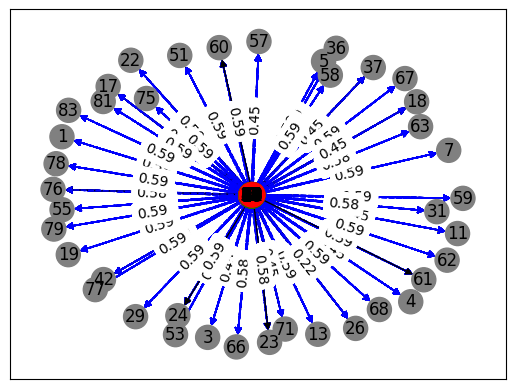

In [25]:
# Create a new directed graph
G = nx.DiGraph()

# Convert node_classification to a dictionary
node_classification_dict = dict(node_classification)

# Add nodes to the graph
node_colors = []
for node in range(node_features.size(0)):
    G.add_node(node)
    if node_features[node].tolist() in [[1, 0], [1, 1]]:
        # Check the node_classification_dict
        node_colors.append('green' if node_classification_dict.get(node, 0) else 'red')
    else:
        node_colors.append('grey')

# Add edges to the graph and store edge weights
edge_weights = defaultdict(list)
for i in range(edge_index.size(1)):
    node1 = edge_index[0, i].item()
    node2 = edge_index[1, i].item()
    weight = 1 - max(predicted_edge_features[i, 1:].tolist())
    G.add_edge(node1, node2, color='black')
    edge_weights[(node1, node2)].append(weight)

# Add new edges to the graph
for i in range(new_edges.size(1)):
    node1 = new_edges[0, i].item()
    node2 = new_edges[1, i].item()
    weight = 1 - max(new_predicted_edge_features[i, 1:].tolist())
    G.add_edge(node1, node2, color='blue')
    edge_weights[(node1, node2)].append(weight)

# Calculate average weights for overlapping edges
for edge in edge_weights:
    edge_weights[edge] = round(sum(edge_weights[edge]) / len(edge_weights[edge]), 2)

# Get the positions of the nodes using the spring layout
pos = nx.spring_layout(G)

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors)

# Draw the edges
edges = G.edges()
edge_colors = [G[u][v]['color'] for u, v in edges]
edge_styles = ['dashed' if G[u][v]['color'] == 'blue' else 'solid' for u, v in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors, style=edge_styles, arrows=True)

# Draw the node labels
nx.draw_networkx_labels(G, pos)

# Draw the edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)

# Show the plot
plt.show()


In [26]:
def finbert_accuracy(stockerbot):
    correct_predictions = 0
    total_predictions = 0

    for index, row in stockerbot.iterrows():
        sentiment = 'Positive' if row['msg_type_logits'][0] > row['msg_type_logits'][1] else 'Negative'
        correct = (sentiment == 'Positive' and row['outcome'] > 0) or (sentiment == 'Negative' and row['outcome'] < 0)
        correct_predictions += correct
        total_predictions += 1

    return correct_predictions / total_predictions

finbert_acc = finbert_accuracy(stockerbot)
print("FinBERT Accuracy: {:.2%}".format(finbert_acc))


FinBERT Accuracy: 67.69%


In [27]:
def full_model_accuracy(stockerbot, node_classification):
    correct_predictions = 0
    total_predictions = 0

    for node, classification in node_classification:
        for index, row in stockerbot[stockerbot['source'] == nodes[node]].iterrows():
            correct = (classification and row['outcome'] > 0) or (not classification and row['outcome'] < 0)
            correct_predictions += correct
            total_predictions += 1

    return correct_predictions / total_predictions if total_predictions > 0 else 0

full_model_acc = full_model_accuracy(stockerbot, node_classification)
print("Full Model Accuracy: {:.2%}".format(full_model_acc))


Full Model Accuracy: 66.15%


In [28]:
print("FinBERT Accuracy: {:.2%}".format(finbert_acc))
print("Full Model Accuracy: {:.2%}".format(full_model_acc))


FinBERT Accuracy: 67.69%
Full Model Accuracy: 66.15%
